In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_hub as hub
import os
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import resample
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import \
    classification_report, \
    confusion_matrix, \
    roc_auc_score, \
    average_precision_score, \
    precision_recall_curve, \
    roc_curve,\
    auc

In [2]:
data_dir = '../input/data'

all_images = glob.glob('{}/*/images/*.png'.format(data_dir))

In [3]:
def move_file(target_dir, df, all_image_paths):

    for img_path in tqdm(all_image_paths):
    
        filename = img_path.split('/')[-1]

        if filename in list(df['image_index']):

            new_img_path = os.path.join(target_dir, filename)

            shutil.copyfile(img_path, new_img_path)

In [4]:
parent_dir = '.'

img_directory = "images"

test_directory = 'test'
valid_directory = 'valid'

img_path = os.path.join(parent_dir, img_directory)

test_path = os.path.join(img_path, test_directory)
valid_path = os.path.join(img_path, valid_directory)

In [5]:
train_test_nih_dir = '../input/nih-data-generator'

test_file = os.path.join(train_test_nih_dir, 'testing_data.csv')
valid_file = os.path.join(train_test_nih_dir, 'validation_data.csv')

test_df = pd.read_csv(test_file, index_col=0)
valid_df = pd.read_csv(valid_file, index_col=0)

In [6]:
if not os.path.isdir(img_path):
    
    mode = 0o666

    os.mkdir(img_path, mode)
  
    os.mkdir(test_path, mode)
    os.mkdir(valid_path, mode)
    
    move_file(test_path, test_df, all_images)
    move_file(valid_path, valid_df, all_images)

100%|██████████| 112120/112120 [00:27<00:00, 4023.41it/s]


In [7]:
test_df['pneumonia'] = test_df['pneumonia'].astype(str)
valid_df['pneumonia'] = valid_df['pneumonia'].astype(str)

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=(224, 224),
    color_mode='rgb'
)

valid_generator=test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_path,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=(224, 224),
    color_mode='rgb'
)

Found 5425 validated image filenames belonging to 2 classes.
Found 1121 validated image filenames belonging to 2 classes.


In [9]:
from keras.models import model_from_json

model_dir = '../input/nih-model-training'

model_json_file = open(os.path.join(model_dir, 'model-1.json'), 'r')  
model_weights_file = os.path.join(model_dir, 'model-1.h5')

model_json = model_json_file.read()
model_json_file.close()

loaded_model = model_from_json(model_json)
loaded_model.load_weights(model_weights_file)

loaded_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2156)              54091884  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              2760960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0

In [10]:
loss, acc = loaded_model.evaluate(test_generator, verbose=1)

85/85 [==============================] - 95s 1s/step - loss: 0.6411 - accuracy: 0.6241


In [11]:
Y_pred = loaded_model.predict(test_generator, verbose=1)

85/85 [==============================] - 96s 1s/step


Best Threshold=0.508275, G-Mean=0.615


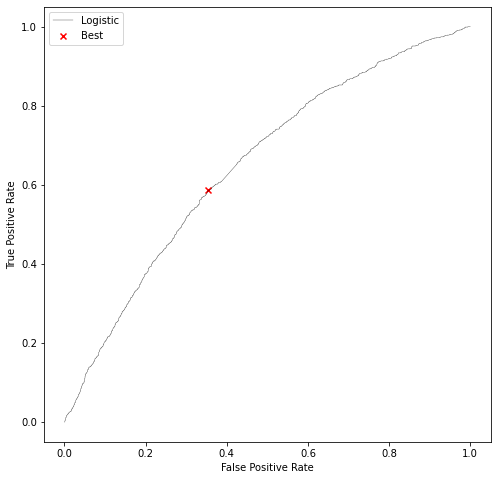

In [12]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, Y_pred)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

best_threshold = thresholds[ix]

print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='Logistic', color='k', linewidth=0.3)
plt.scatter(fpr[ix], tpr[ix], marker='x', color='r', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [13]:
classes = ['NORMAL', 'PNEUMONIA']

In [14]:
def generate_prediction_by_prob(prob, threshold=0.508275):
    
    return prob>threshold

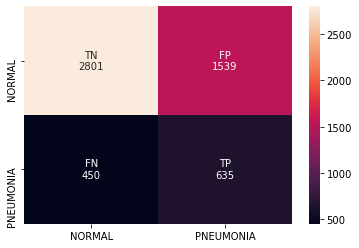

In [15]:
cf_matrix = confusion_matrix(test_generator.classes, generate_prediction_by_prob(Y_pred, best_threshold))

group_names = ['TN', 'FP', 'FN', 'TP']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(
    cf_matrix, 
    annot=labels,
    xticklabels=classes,
    yticklabels=classes,
    fmt=''
)

plt.show()

In [16]:
print(classification_report(
    test_generator.classes, generate_prediction_by_prob(Y_pred, best_threshold), target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.86      0.65      0.74      4340
   PNEUMONIA       0.29      0.59      0.39      1085

    accuracy                           0.63      5425
   macro avg       0.58      0.62      0.56      5425
weighted avg       0.75      0.63      0.67      5425



In [17]:
def plot_precision_recall_curve(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    
    c_ax.legend()
    
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

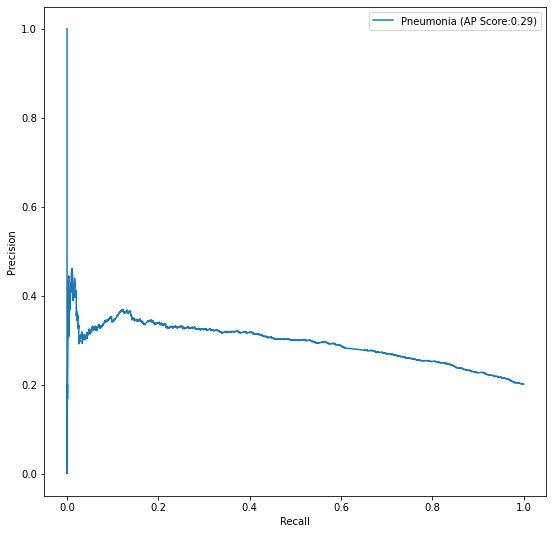

In [18]:
plot_precision_recall_curve(test_generator.classes, Y_pred)

In [19]:
def plot_threshold_f1score_curve(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    c_ax.plot(thresholds, f1_score[1:])
    
    c_ax.legend()
    
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1-score')
    
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


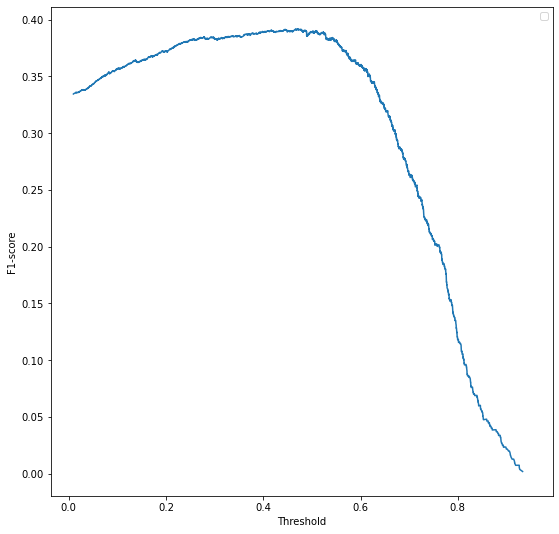

In [20]:
plot_threshold_f1score_curve(test_generator.classes, Y_pred)

In [21]:
def plot_roc_curve(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    
    c_ax.legend()
    
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

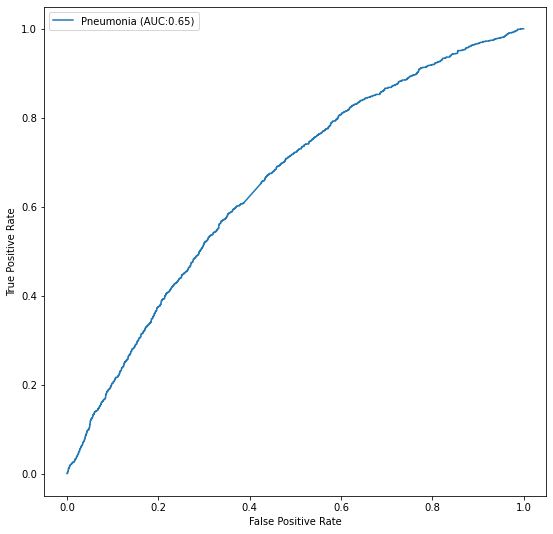

In [22]:
plot_roc_curve(test_generator.classes, Y_pred)

In [23]:
Y_pred = loaded_model.predict(valid_generator, verbose=1)

18/18 [==============================] - 19s 1s/step


Best Threshold=0.452585, G-Mean=0.616


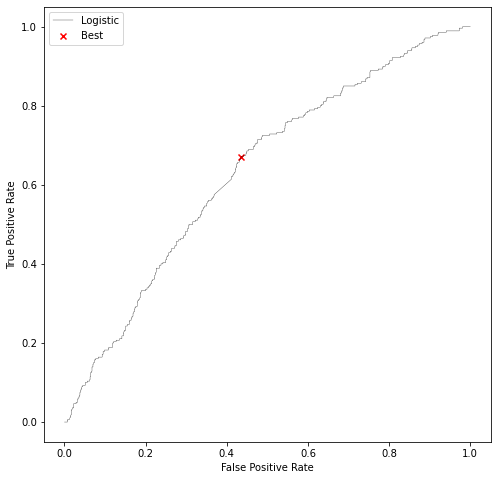

In [24]:
fpr, tpr, thresholds = roc_curve(valid_generator.classes, Y_pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

best_threshold = thresholds[ix]

print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='Logistic', color='k', linewidth=0.3)
plt.scatter(fpr[ix], tpr[ix], marker='x', color='r', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


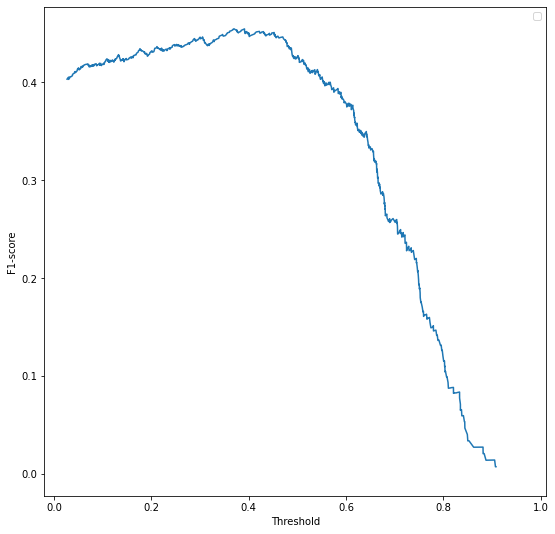

In [25]:
plot_threshold_f1score_curve(valid_generator.classes, Y_pred)

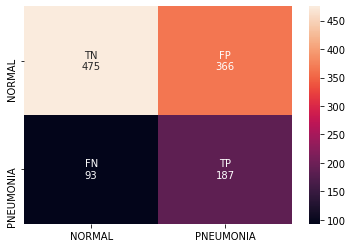

In [26]:
cf_matrix = confusion_matrix(valid_generator.classes, generate_prediction_by_prob(Y_pred, best_threshold))

group_names = ['TN', 'FP', 'FN', 'TP']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(
    cf_matrix, 
    annot=labels,
    xticklabels=classes,
    yticklabels=classes,
    fmt=''
)

plt.show()

In [27]:
print(classification_report(
    valid_generator.classes, generate_prediction_by_prob(Y_pred, best_threshold), target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.84      0.56      0.67       841
   PNEUMONIA       0.34      0.67      0.45       280

    accuracy                           0.59      1121
   macro avg       0.59      0.62      0.56      1121
weighted avg       0.71      0.59      0.62      1121



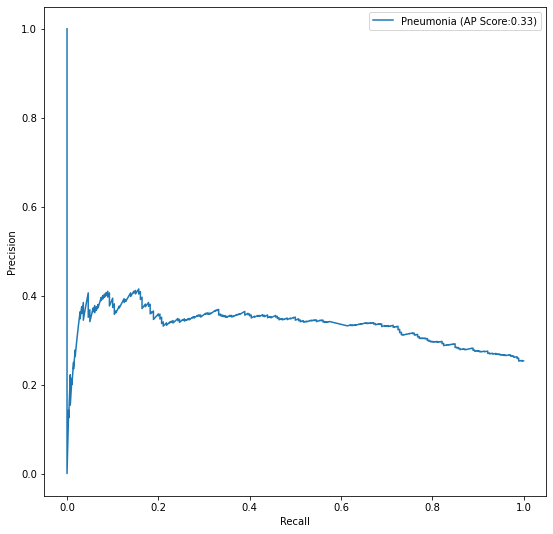

In [28]:
plot_precision_recall_curve(valid_generator.classes, Y_pred)

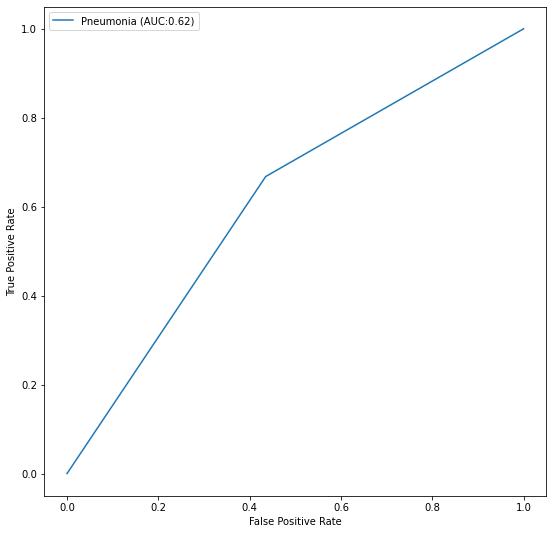

In [29]:
plot_roc_curve(valid_generator.classes, generate_prediction_by_prob(Y_pred, best_threshold))

In [30]:
!rm -r './images'